# Major notes and ideas:

- make unecessery model diagnostics or computed values as on_demand variables instead, this improves efficiency (if they do not have to be calculated at every step)

- add index variable functionality! but how?

-

In [1]:
import xso

In [2]:
# start testing base functionality
xso.variable()

xso.component()

<function xso.component.component.<locals>.create_component(cls)>

In [3]:
import xsimlab as xs

In [4]:
xs.process()

<function xsimlab.process.process.<locals>.wrap(cls)>

In [5]:
import xsimlab as xs

from xso.core import XSOCore


@xs.process
class Backend:
    """this object contains the backend model and is modified or read by all other components"""

    solver_type = xs.variable(intent='in')
    m = xs.any_object(description='model backend instance is stored here')

    def initialize(self):
        print('initializing model backend')
        self.m = PhydraCore(self.solver_type)

    def finalize(self):
        print('finalizing: cleanup')
        self.m.cleanup()  # for now only affects gekko solve

In [6]:
Backend

__main__.Backend

# Now Test The Global Ref option

- test the feature, if is incorporated into XSO, now is the time!
- go through and update the framework, then build Phydra with new funcs

In [7]:
@xs.process
class Globally:
    glo = xs.global_ref(name="A")
    testgroup = xs.group_dict(name="G")
    
    def initialize(self):
        print(self.glo)
        print(self.testgroup)
        
    def finalize(self):
        print("finalize globally")
        print(self.testgroup)

In [8]:
@xs.process
class Varr:
    a = xs.variable(global_name="A")
    
    b = xs.variable(groups="G")
    c = xs.variable(groups="G")
    
    def run(self):
        print(self.a)
        self.a = 2
        print(self.a)
        
    def finalize(self):
        print("finalize Varr")
        print(self.a)

In [9]:
testmod = xs.Model({'g':Globally, 'var':Varr})

In [10]:
test = xs.create_setup(model=testmod, 
                       clocks={'time':[0,1]},
                       input_vars={'var':{'a':1, 'b':'B', 'c':3}})

In [11]:
with testmod:
    test.xsimlab.run()

1
Frozen({('var', 'b'): 'B', ('var', 'c'): 3})
finalize globally
Frozen({('var', 'b'): 'B', ('var', 'c'): 3})
finalize Varr
1


# Should I build it from "scratch"?

- or start modifying, and then go through and trim?

seems like the second option is more efficient, can always do a full rewrite part per part

hm... now, where to start?

build "test" xso components, then go through backend and modify, whilst testing basic functionality

In [1]:
import xso

In [2]:
@xso.component(init_stage=2)
class Variable:
    var = xso.variable(description='basic state variable')
    
@xso.component(init_stage=2)
class Variable_with_dims:
    var = xso.variable(dims='var', description='basic state variable')
    
@xso.component(init_stage=3)
class Flux:
    """ basic flux process for testing 
    represents linear growth of a foreign variable
    """
    var = xso.variable(foreign=True, flux='growth', 
                       negative=False, description='variable affected by flux',
                      dims=[(),('var')])
    rate = xso.parameter(description='linear rate of change',
                      dims=[(),('var')])

    @xso.flux(dims=[(),('var')])
    def growth(self, var, rate):
        """ """
        return var * rate

In [3]:
MODEL = xso.create({"Var":Variable, "VarDims":Variable_with_dims, "Flux":Flux, "Flux_dims":Flux})

In [4]:
MODEL

<xsimlab.Model (7 processes, 10 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) sequence of time points fo...
Var
    var_label       [in] label / basic state variable
    var_init        [in] initial value / basic state variable
VarDims
    var_label       [in] label / basic state variable
    var_init        [in] ('var',) initial value / basic state variable
Flux
    var             [in] label reference / variable affected by flux
    rate            [in] () or ('var',) linear rate of change
Flux_dims
    var             [in] label reference / variable affected by flux
    rate            [in] () or ('var',) linear rate of change
Solver

In [8]:
import numpy as np

SETUP = xso.setup(solver='odeint', model=MODEL,
            time=np.arange(0,5),
            input_vars={'Var':{'var_label':'A', 'var_init':1.},
                        'VarDims':{'var_label':'B', 'var_init':[1.,2.]},
                        'Flux':{'var':'A', 'rate':1.},
                        'Flux_dims':{'var':'B', 'rate':[1.,0.5]},
                       }
         )

In [9]:
with MODEL:
    OUTPUT = SETUP.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Var
Initializing component VarDims
Initializing component Flux
Initializing component Flux_dims
assembling model
SOLVER : <xso.solvers.ODEINTSolver object at 0x7f6490786da0>
Model is assembled:
Model contains: 
Variables:['time', 'A', 'B'] 
Parameters:['Flux_rate', 'Flux_dims_rate'] 
Forcings:[] 
Fluxes:['Time_time_flux', 'Flux_growth', 'Flux_dims_growth'] 
Full Model Dimensions:[('time', None), ('A', None), ('B', 2), ('Time_time_flux', None), ('Flux_growth', None), ('Flux_dims_growth', 2)] 

finalizing: cleanup
Model was solved in 0.02287 seconds


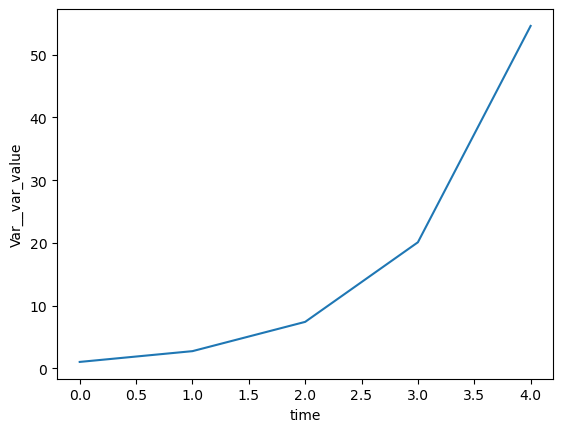

In [12]:
OUTPUT.Var__var_value.plot()